In [1]:
import quantecon as qe
import numpy as np
from gurobipy import *

In [2]:
class SimpleOG(object):

    def __init__(self, B=10, M=5, alpha=0.5, beta=0.9):

        self.B, self.M, self.alpha, self.beta  = B, M, alpha, beta
        self.n = B + M + 1
        self.m = M + 1

        self.R = np.empty((self.n, self.m))
        self.Q = np.zeros((self.n, self.m, self.n))

        self.populate_Q()
        self.populate_R()

    def u(self, c):
        return c**self.alpha

    def populate_R(self):

        for s in range(self.n):
            for a in range(self.m):
                self.R[s, a] = self.u(s - a) if a <= s else -np.inf

    def populate_Q(self):

        for a in range(self.m):
            self.Q[:, a, a:(a + self.B + 1)] = 1.0 / (self.B + 1)

In [3]:
g = SimpleOG()

In [5]:
# n = 16
# m = 6
ddp = qe.markov.DiscreteDP(g.R, g.Q, g.beta)

In [9]:
# reward array
ddp.R

array([[ 0.        ,        -inf,        -inf,        -inf,        -inf,
               -inf],
       [ 1.        ,  0.        ,        -inf,        -inf,        -inf,
               -inf],
       [ 1.41421356,  1.        ,  0.        ,        -inf,        -inf,
               -inf],
       [ 1.73205081,  1.41421356,  1.        ,  0.        ,        -inf,
               -inf],
       [ 2.        ,  1.73205081,  1.41421356,  1.        ,  0.        ,
               -inf],
       [ 2.23606798,  2.        ,  1.73205081,  1.41421356,  1.        ,
         0.        ],
       [ 2.44948974,  2.23606798,  2.        ,  1.73205081,  1.41421356,
         1.        ],
       [ 2.64575131,  2.44948974,  2.23606798,  2.        ,  1.73205081,
         1.41421356],
       [ 2.82842712,  2.64575131,  2.44948974,  2.23606798,  2.        ,
         1.73205081],
       [ 3.        ,  2.82842712,  2.64575131,  2.44948974,  2.23606798,
         2.        ],
       [ 3.16227766,  3.        ,  2.82842712,  2.

In [10]:
# transition probability array
ddp.Q

array([[[ 0.09090909,  0.09090909,  0.09090909, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.09090909,  0.09090909, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.09090909, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.09090909,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.09090909,
          0.09090909,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.09090909,
          0.09090909,  0.09090909]],

       [[ 0.09090909,  0.09090909,  0.09090909, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.09090909,  0.09090909, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.09090909, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.09090909,
          0.  

In [11]:
# discount factor
ddp.beta

0.9

In [12]:
# number of states
ddp.num_states

16

In [13]:
# number of actions
ddp.num_actions

6

In [14]:
# number of pairs of actions and states
ddp.num_sa_pairs

81

In [7]:
#exact LP
#　変数の導入（ここではvalue function）
num_state = range(1, ddp.num_states + 1)
num_action = range(1, ddp.num_actions + 1)
LP = gp.Model()

x = {}
for i in num_state:
    x[i ] = LP.addVar(vtype = "C", name = "x(%s)" %(i))
LP.update()

In [8]:
x

{1: <gurobi.Var x(1)>,
 2: <gurobi.Var x(2)>,
 3: <gurobi.Var x(3)>,
 4: <gurobi.Var x(4)>,
 5: <gurobi.Var x(5)>,
 6: <gurobi.Var x(6)>,
 7: <gurobi.Var x(7)>,
 8: <gurobi.Var x(8)>,
 9: <gurobi.Var x(9)>,
 10: <gurobi.Var x(10)>,
 11: <gurobi.Var x(11)>,
 12: <gurobi.Var x(12)>,
 13: <gurobi.Var x(13)>,
 14: <gurobi.Var x(14)>,
 15: <gurobi.Var x(15)>,
 16: <gurobi.Var x(16)>}

In [9]:
#　制約の追加
for i in num_state:
    for j in num_action:
        LP.addConstr((x[i] - ddp.beta * quicksum(ddp.Q[i-1, j-1, k-1] * x[k] for k in num_state)) >= ddp.R[i-1,j-1])

LP.update()

In [11]:
#　目的関数の設定
LP.setObjective(quicksum(x[i] for i in num_state))
LP.update()

In [13]:
# 求解
LP.ModelSense = 1
LP.optimize()

for v in LP.getVars():
    print v.VarName ,v.X

Optimize a model with 96 rows, 16 columns and 1086 nonzeros
Coefficient statistics:
  Matrix range    [8e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]

Solved in 31 iterations and 0.00 seconds
Optimal objective  3.471108093e+02
x(1) 19.017402217
x(2) 20.017402217
x(3) 20.4316157793
x(4) 20.7494530245
x(5) 21.0407809911
x(6) 21.3087301835
x(7) 21.544798161
x(8) 21.7692818108
x(9) 21.9827035761
x(10) 22.1882432282
x(11) 22.3845047965
x(12) 22.5780773639
x(13) 22.7610912698
x(14) 22.9437670835
x(15) 23.1153399587
x(16) 23.2776176189


In [44]:
# 真の値
results = ddp.solve(method='policy_iteration')

In [45]:
results.v

array([ 19.01740222,  20.01740222,  20.43161578,  20.74945302,
        21.04078099,  21.30873018,  21.54479816,  21.76928181,
        21.98270358,  22.18824323,  22.3845048 ,  22.57807736,
        22.76109127,  22.94376708,  23.11533996,  23.27761762])

In [9]:
#時間計測
import timeit
% timeit ddp.solve(method='policy_iteration')

1000 loops, best of 3: 280 µs per loop


In [5]:
#時間計測関数
def elapse(setting):
    start = time.time()
    setting.solve(method='policy_iteration')
    elapsed_time = time.time() - start
    return elapsed_time

In [10]:
# 関数にする
import quantecon as qe
import numpy as np
from gurobipy import *

def LP_approach(setting):
    num_state = range(1, setting.num_states + 1)
    num_action = range(1, setting.num_actions + 1)
    LP = Model()

    x = {}
    for i in num_state:
        x[i ] = LP.addVar(vtype = "C", name = "x(%s)" %(i))
    LP.update()
    
    for i in num_state:
        for j in num_action:
            LP.addConstr((x[i] - setting.beta * quicksum(setting.Q[i-1, j-1, k-1] * x[k] for k in num_state)) >= setting.R[i-1,j-1])
            
    LP.setObjective(quicksum(x[i] for i in num_state))
    LP.optimize()
    
    return LP.Runtime

In [11]:
LP_approach(ddp)

Optimize a model with 96 rows, 16 columns and 1086 nonzeros
Coefficient statistics:
  Matrix range    [8e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.01s
Presolved: 16 rows, 96 columns, 1086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.874222e+02      0s
      31    3.4711081e+02   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.02 seconds
Optimal objective  3.471108093e+02


0.02172684669494629

In [12]:
% matplotlib inline

In [13]:
#時間
import matplotlib.pyplot as plt

Optimize a model with 96 rows, 16 columns and 1086 nonzeros
Coefficient statistics:
  Matrix range    [8e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.00s
Presolved: 16 rows, 96 columns, 1086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.874222e+02      0s
      31    3.4711081e+02   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds
Optimal objective  3.471108093e+02
Optimize a model with 102 rows, 17 columns and 1254 nonzeros
Coefficient statistics:
  Matrix range    [7e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.01s
Presolved: 17 rows, 102 columns, 1254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   2.094231e+02      0s
      31    3.8637659e+02   0.0

(10, 200)

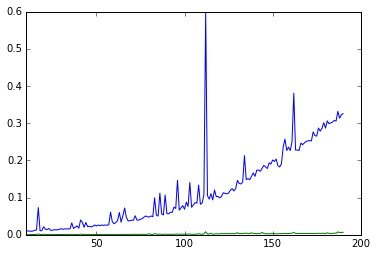

In [20]:
# Bを増やしてみる
# exact LPがいかに遅いか
a = []
b = []
for i in range(10, 201):
    h = SimpleOG(B = i)
    ddp = qe.markov.DiscreteDP(h.R, h.Q, h.beta)
    a.append(LP_approach(ddp))
    b.append(elapse(ddp))

plt.plot(a)
plt.plot(b)
plt.xlim(10,200)

In [14]:
# もう少し早くグラフを出したい
# None 配列の乗算
list = [None] * 5

In [15]:
list

[None, None, None, None, None]

In [17]:
import time

Optimize a model with 96 rows, 16 columns and 1086 nonzeros
Coefficient statistics:
  Matrix range    [8e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.00s
Presolved: 16 rows, 96 columns, 1086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.874222e+02      0s
      31    3.4711081e+02   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds
Optimal objective  3.471108093e+02
Optimize a model with 102 rows, 17 columns and 1254 nonzeros
Coefficient statistics:
  Matrix range    [7e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.01s
Presolved: 17 rows, 102 columns, 1254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   2.094231e+02      0s
      31    3.8637659e+02   0.0

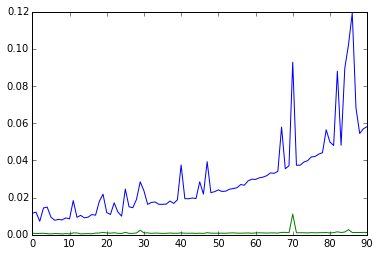

In [20]:
# Noneを使って
# すこしはやいかも
a = [None] * 91
b = [None] * 91
for i in range(10, 101):
    h = SimpleOG(B = i)
    d = qe.markov.DiscreteDP(h.R, h.Q, h.beta)
    a[i - 10] = LP_approach(d)
    b[i - 10] = elapse(d)

plt.plot(a)
plt.plot(b)

Optimize a model with 96 rows, 16 columns and 1086 nonzeros
Coefficient statistics:
  Matrix range    [8e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.00s
Presolved: 16 rows, 96 columns, 1086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.874222e+02      0s
      31    3.4711081e+02   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds
Optimal objective  3.471108093e+02
Optimize a model with 102 rows, 17 columns and 1254 nonzeros
Coefficient statistics:
  Matrix range    [7e-02, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.00s
Presolved: 17 rows, 102 columns, 1254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   2.094231e+02      0s
      31    3.8637659e+02   0.0

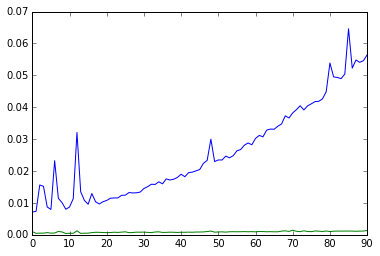

In [23]:
# numba ?
from numba.decorators import jit
import quantecon as qe
import numpy as np
from gurobipy import *

@jit

def elapse(setting):
    start = time.time()
    setting.solve(method='policy_iteration')
    elapsed_time = time.time() - start
    return elapsed_time

def LP_approach(setting):
    num_state = range(1, setting.num_states + 1)
    num_action = range(1, setting.num_actions + 1)
    LP = Model()

    x = {}
    for i in num_state:
        x[i ] = LP.addVar(vtype = "C", name = "x(%s)" %(i))
    LP.update()
    
    for i in num_state:
        for j in num_action:
            LP.addConstr((x[i] - setting.beta * quicksum(setting.Q[i-1, j-1, k-1] * x[k] for k in num_state)) >= setting.R[i-1,j-1])
            
    LP.setObjective(quicksum(x[i] for i in num_state))
    LP.optimize()
    
    return LP.Runtime

if __name__ == '__main__':
    a = [None] * 91
    b = [None] * 91
    for i in range(10, 101):
        h = SimpleOG(B = i)
        d = qe.markov.DiscreteDP(h.R, h.Q, h.beta)
        a[i - 10] = LP_approach(d)
        b[i - 10] = elapse(d)

    plt.plot(a)
    plt.plot(b)

In [27]:
# グラフ化はしないけど
large_size = SimpleOG(B = 1000 , M = 500)
d = qe.markov.DiscreteDP(h.R, h.Q, h.beta)
print "LP time =" ,  LP_approach(d)
print "DP time =", elapse(d)

LP time =Optimize a model with 636 rows, 106 columns and 64266 nonzeros
Coefficient statistics:
  Matrix range    [9e-03, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+00, 1e+100]
Presolve time: 0.03s
Presolved: 106 rows, 636 columns, 64266 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   4.180515e+03      0s
     158    7.1247774e+03   0.000000e+00   0.000000e+00      0s

Solved in 158 iterations and 0.06 seconds
Optimal objective  7.124777363e+03
 0.0577969551086
DP time = 0.00194501876831


In [ ]:
# やっぱりなにかおかしい